<a href="https://colab.research.google.com/github/The-begining/sentimentAnalysis_amazonreview/blob/main/Experimental_setup_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/training_set_cleaned.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test_dataset_cleaned.csv')

In [4]:
train_df['Sentiments'] = train_df['Sentiments'].astype(int)
test_df['Sentiments'] = test_df['Sentiments'].astype(int)


train_df['text'] = train_df['text'].astype(str).fillna('')
test_df['text'] = test_df['text'].astype(str).fillna('')

In [5]:
train_df['text'][1]

'the best soundtrack ever to anythingim reading a lot of reviews saying that this is the best game soundtrack and i figured that id write a review to disagree a bit this in my opinino is yasunori mitsudas ultimate masterpiece the music is timeless and im been listening to it for years now and its beauty simply refuses to fadethe price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny'

In [6]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [8]:
# Define a function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Lemmatize each token and join them back into a single string
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text

In [ ]:
#train_df = train_df.sample(n = 50000, random_state=42)
#test_df = test_df.sample(n=10000, random_state=42)


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Download necessary NLTK data
nltk.download('stopwords')
# Initialize the set of stop words
stop_words = set(stopwords.words('english'))

# Define a function to remove stop words
def remove_stop_words(text):
    words = word_tokenize(text) # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words] # Filter out stop words
    filtered_text = ' '.join(filtered_words)  # Join the filtered words back into a single string
    return filtered_text

# Apply the function to the 'text' column of the train and test Dataset
train_df['text'] = train_df['text'].apply(remove_stop_words)
test_df['text'] = test_df['text'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
train_df['text'][1]

'best soundtrack ever anythingim reading lot reviews saying best game soundtrack figured id write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless im listening years beauty simply refuses fadethe price tag pretty staggering must say going buy cd much money one feel would worth every penny'

In [11]:
train_df.shape

(2400000, 3)

In [12]:
# Lemmatization
train_df['text'] = train_df['text'].apply(lemmatize_text)
test_df['text'] = test_df['text'].apply(lemmatize_text)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Data Preparation
train_texts = train_df['text'].values
train_labels = train_df['Sentiments'].values
test_texts = test_df['text'].values
test_labels = test_df['Sentiments'].values

In [15]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

max_sequence_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)

In [16]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense

def TransformerLayer(units, num_heads, dropout, activation='relu'):
    inputs = Input(shape=(None, units))
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units // num_heads)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)
    outputs = Dense(units, activation=activation)(attention)
    outputs = Dropout(dropout)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)
    return Model(inputs=inputs, outputs=outputs)

transformer_layer = TransformerLayer(units=128, num_heads=2, dropout=0.1)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [18]:
max_sequence_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)

In [19]:

# Model Architecture
inputs = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(inputs)
transformer_output = TransformerLayer(units=128, num_heads=2, dropout=0.1)(embedding_layer)
pooling_layer = GlobalAveragePooling1D()(transformer_output)
dropout_layer = Dropout(0.2)(pooling_layer)
outputs = Dense(1, activation='sigmoid')(dropout_layer)

In [20]:
# Create the model
model = Model(inputs=inputs, outputs=outputs)

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [23]:
# Training
history = model.fit(train_sequences, train_labels, validation_data=(test_sequences, test_labels), epochs=1, batch_size=2048, callbacks=[early_stopping])

1172/1172 [==============================] - 467s 392ms/step - loss: 0.3114 - accuracy: 0.8643 - val_loss: 0.2752 - val_accuracy: 0.8842


In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16250/16250 [==============================] - 75s 5ms/step - loss: 0.2752 - accuracy: 0.8842
Test Loss: 0.2752498984336853, Test Accuracy: 0.8841844201087952


In [26]:
# Predict the test set
y_pred_probs = model.predict(test_sequences)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred))


16250/16250 [==============================] - 59s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88    259999
           1       0.88      0.89      0.89    260000

    accuracy                           0.88    519999
   macro avg       0.88      0.88      0.88    519999
weighted avg       0.88      0.88      0.88    519999



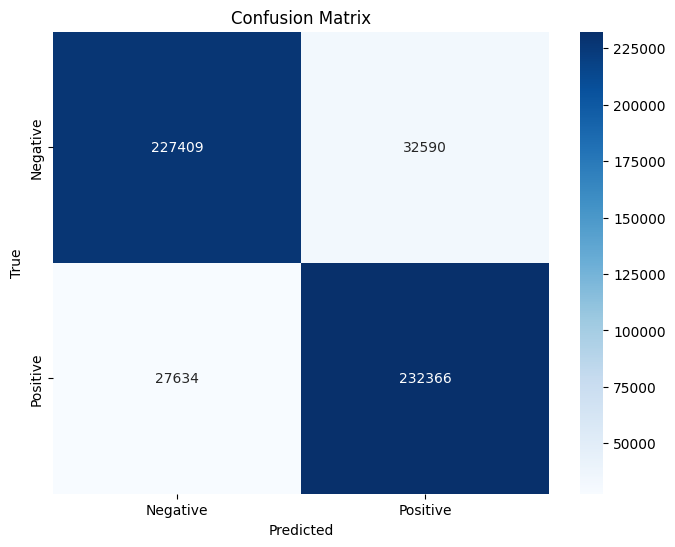

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


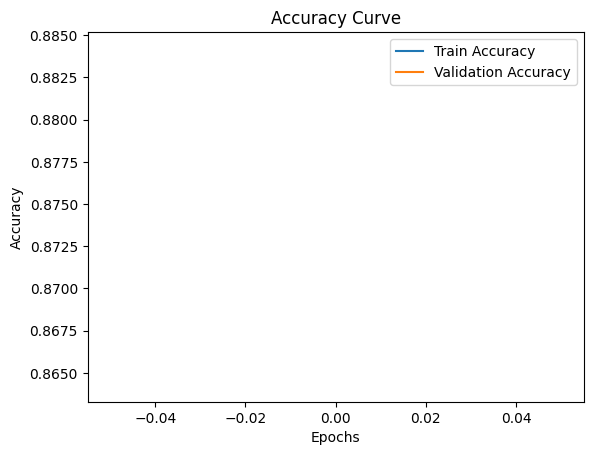

In [28]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()